###  Leveraging Machine Learning to predict reservoir rocks in an oil and gas field offshore Norway

#### INTRODUCTION

1. In this study, four supervised machine learning algorithms have been utilized for the classification of lithofacies from geophysical well logs within the ‘Volve’ Field. This project was completed in October 2018 and it was built upon work in the following notebook https://github.com/seg/2016-ml-contest/blob/master/Facies_classification.ipynb

2. This work was done using Python's main scientific libraries, particularly NumPy, Pandas, SciPy, and Matplotlib as well as the production-ready Python framework for machine learning: Scikit-Learn.

*For Non-Geoscience readers, lithofacies are basically rock types and stacking patterns are basically the trends in grain size. Lithofacies classification based on well log data is often the basis of reservoir parameter calculations, and provide the foundation for many subsurface geological research studies.



#### STATEMENT OF THE PROBLEM

Lithofacies classification can be tedious and time consuming, and it is prone to subjective bias because different geologists are likely to come up with different interpretations from the same dataset. Although core samples which are obtained during drilling provide a more accurate representation of the subsurface geology than interpretations made from geophysical well logs, they are not always available for all wells within a field due to their expense. Therefore, a fast and efficient method of accurately classifying the lithofacies in a large number of wells without core samples, and with minimum subjective bias is necessary. This informed the use of supervised machine learning for the classification of lithofacies from geophysical logs in wells without cores within the ‘Volve’ Field, Norwegian North Sea.



#### CONCLUSION

1. The results show that all the algorithms – Naïve Bayes, Support Vector Machine, K-Nearest Neighbour, and Decision Trees – correctly classify at least sixty-eight (68) per cent of the tidal channel sandstones, which is the lithofacies of interest. However, the Support Vector Machine (SVM) classifier is the most effective classifier in this study. 

2. The results also show that the four machine learning algorithms are currently unable to detect spatial relationships between the well logs samples, and thus are unable to recognize stacking patterns in the gamma ray logs. Consequently, they are unable to correctly classify most of the other lithofacies, within the study area, which have non-uniform gamma ray readings i.e. progradational and aggradational stacking patterns as well as serrated log motifs.



#### RECOMMENDATIONS

1. The Support Vector Machine (SVM) classifier should be deployed for the prediction of the tidal channel facies within the ‘Volve’ Field in order to improve the efficiency and speed of lithofacies classification as well as reduce the uncertainty associated with field development decisions. However, it should not be deployed for the prediction of other lithofacies with complex stacking patterns.

2. Research should be carried out in order to develop machine learning algorithms specific to the geoscience domain as most generic ML algorithms are ineffective in solving lithofacies classification problems due to the high spatial correlation within well log data. Corrollary, care should be taken when utilizing generic machine learning algorithms on subsurface data (well data) to solve geoscience related problems.

Import required libraries

In [1]:
import scipy
import numpy as np
import pandas as pd
pd.set_option('expand_frame_repr', False)
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.constrained_layout.use'] = True
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sklearn
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder


#### IMPORT AND INITIALLY PREPROCESS THE DATA
1. Import training and test data
2. Rename columns to prevent errors due to illegal characters when columns are accessed
3. Encode the labels and print out the result

In [2]:
training_data = pd.read_csv('training_data.csv')
print(training_data.head(n=11))
test_data = pd.read_csv('test_data.csv')
#print(test_data.head(n=11))

#print(training_data.describe())
#print(test_data.describe())

#Edit the column names cos the forward slash included in the units might break the code when the columns are called.
new_column_names = ['Well_Name', 'MD', 'P_sonic', 'Gamma', 'Neutron', 'Density', 'Vshale', 'Facies']
training_data.columns = new_column_names
test_data.columns = new_column_names

#Encode the labels
le = LabelEncoder()
training_data['Facies'] = le.fit_transform(training_data['Facies'])
test_data['Facies'] = le.fit_transform(test_data['Facies'])
le_facies_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

#print(training_data.head(n=11))
#print(test_data.head(n=11))
print(le_facies_mapping)
list_of_facies_codes = list(le_facies_mapping.values())
print(list_of_facies_codes)    

         Well_Name  MD(metres)  P_sonic(us/ft)  Gamma(gAPI)  Neutron(m3/ms)  DENSITY(g/cm3)  VSHALE        FACIES
0   Well 15_9-19_A    3821.582           78.34        28.32            0.20            2.33     0.21  F-TIDAL BAR
1   Well 15_9-19_A    3821.735           77.24        26.70            0.23            2.34     0.18  F-TIDAL BAR
2   Well 15_9-19_A    3821.887           76.24        24.17            0.14            2.49     0.14  F-TIDAL BAR
3   Well 15_9-19_A    3822.040           75.48        25.47            0.16            2.49     0.16  F-TIDAL BAR
4   Well 15_9-19_A    3822.192           74.94        23.38            0.16            2.50     0.12  F-TIDAL BAR
5   Well 15_9-19_A    3822.344           74.56        25.05            0.16            2.51     0.15  F-TIDAL BAR
6   Well 15_9-19_A    3822.497           74.45        22.86            0.15            2.52     0.12  F-TIDAL BAR
7   Well 15_9-19_A    3822.649           74.86        25.28            0.19            2

Define a color map for the facies classes to ensure consistency during visualization.

In [3]:
facies_labels = ['F-LOWER SHOREFACE', 'F-MARSH', 'F-MOUTHBAR', 'F-OFFSHORE', 'F-TIDAL BAR', 'F-TIDAL CHANNEL', 'F-UPPER SHOREFACE']

facies_colors = ['#c17139','#b662c1','#c13898','#535659','#2A9DE0','#28A34F','#ece665']

#facies_color_map is a dictionary that maps facies labels
#to their respective colors

facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

print(facies_color_map)

{'F-LOWER SHOREFACE': '#c17139', 'F-MARSH': '#b662c1', 'F-MOUTHBAR': '#c13898', 'F-OFFSHORE': '#535659', 'F-TIDAL BAR': '#2A9DE0', 'F-TIDAL CHANNEL': '#28A34F', 'F-UPPER SHOREFACE': '#ece665'}


#### EDA1: VISUALIZE THE DATA USING MATPLOTLIB

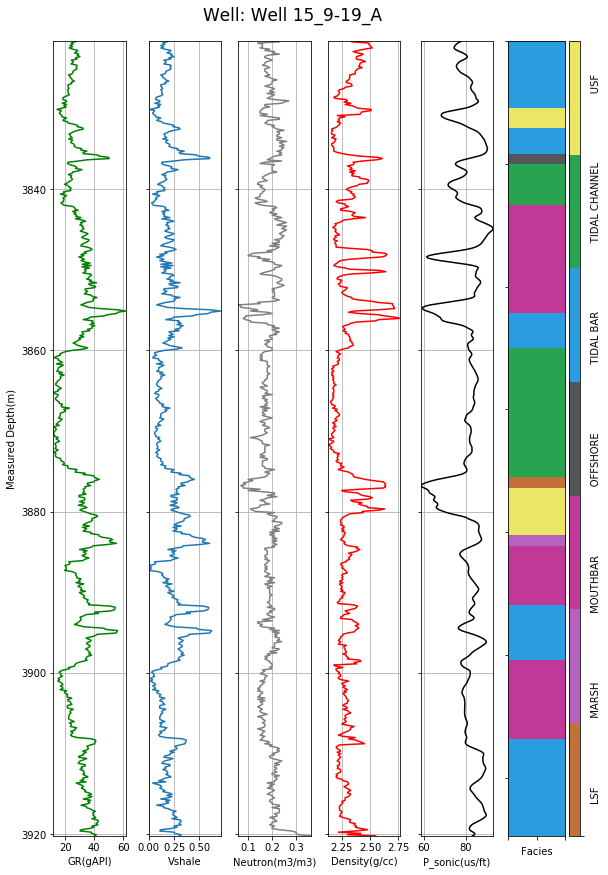

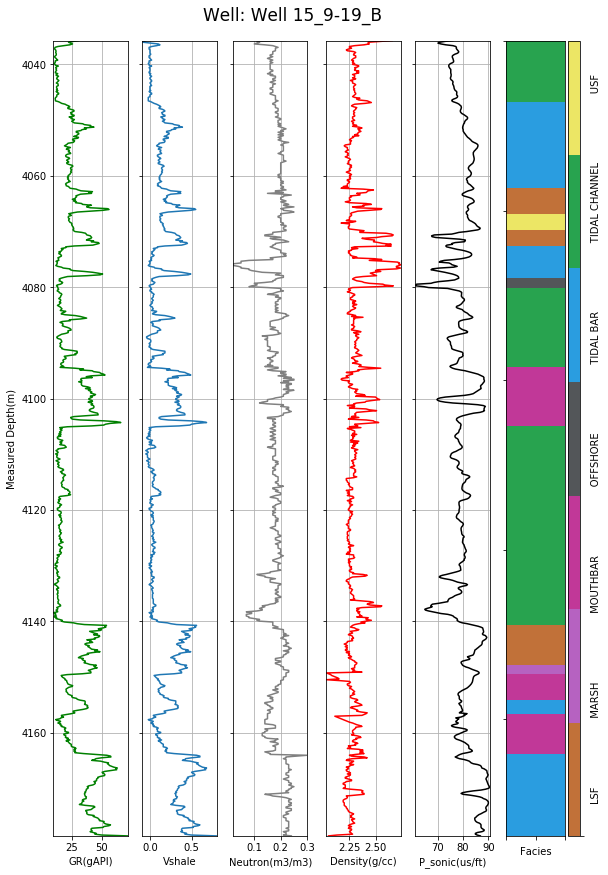

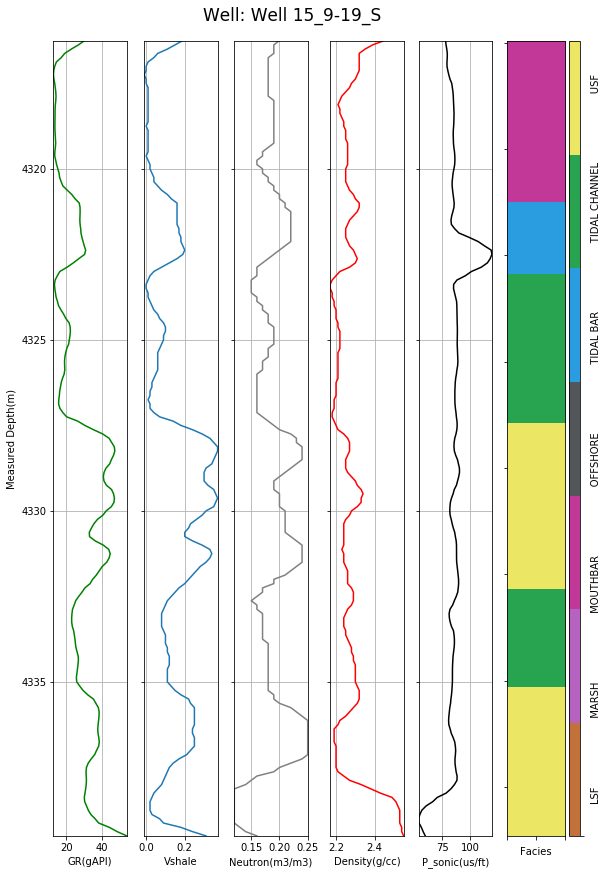

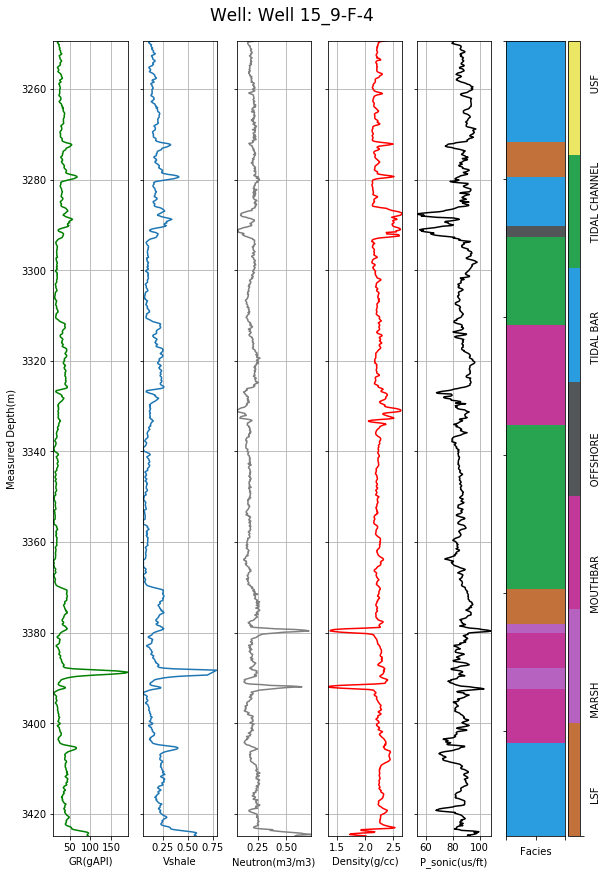

In [4]:
def  make_facies_log_plot (logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='MD')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.MD.min(); zbot=logs.MD.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.Gamma, logs.MD, '-g')
    ax[1].plot(logs.Vshale, logs.MD, '-')
    ax[2].plot(logs.Neutron, logs.MD, '-', color='0.5')
    ax[3].plot(logs.Density, logs.MD, '-', color='r')
    ax[4].plot(logs.P_sonic, logs.MD, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=6)
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((22*' ').join(['LSF', 'MARSH', 'MOUTHBAR', 'OFFSHORE', 'TIDAL BAR', 'TIDAL CHANNEL', 'USF']
))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR(gAPI)")
    ax[0].set_ylabel("Measured Depth(m)")
    ax[0].set_xlim(logs.Gamma.min(),logs.Gamma.max())
    ax[1].set_xlabel("Vshale")
    ax[1].set_xlim(logs.Vshale.min(),logs.Vshale.max())
    ax[2].set_xlabel("Neutron(m3/m3)")
    ax[2].set_xlim(logs.Neutron.min(),logs.Neutron.max())
    ax[3].set_xlabel("Density(g/cc)")
    ax[3].set_xlim(logs.Density.min(),logs.Density.max())
    ax[4].set_xlabel("P_sonic(us/ft)")
    ax[4].set_xlim(logs.P_sonic.min(),logs.P_sonic.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well_Name'], fontsize=17,y=1)
    
make_facies_log_plot(training_data[training_data['Well_Name'] == 'Well 15_9-19_A'], facies_colors)

make_facies_log_plot(training_data[training_data['Well_Name'] == 'Well 15_9-19_B'], facies_colors)

make_facies_log_plot(training_data[training_data['Well_Name'] == 'Well 15_9-19_S'], facies_colors)

make_facies_log_plot(training_data[training_data['Well_Name'] == 'Well 15_9-F-4'], facies_colors)    

#### EDA2: VISUALIZATION OF TRAINING DATA TO DETERMINE FACIES DISTRIBUTION

F-LOWER SHOREFACE    208
F-MARSH               63
F-MOUTHBAR           660
F-OFFSHORE            36
F-TIDAL BAR          851
F-TIDAL CHANNEL      960
F-UPPER SHOREFACE    148
Name: Facies, dtype: int64

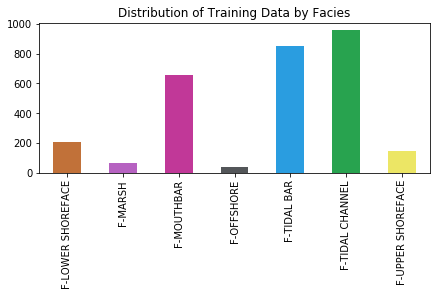

In [5]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

#### FEATURE ENGINEERING FOR THE TRAINING DATA (BASED ON DOMAIN KNOWLEDGE)
1. Facies do not always abruptly change from a given depth layer to the next one (except in the casses of flooding and trangressive surfaces). Therefore, neighbouring facies are expected to be somehow related, and these can be accounted for using the following steps below.

2. Tasks
First Step: Aggregrate features at neighbouring depths and compute the gradient for the training data using the GR and Depth logs
Second Step: Add the gradient to the dataset

In [46]:
#First Step
i = 4
gradient_list = []
depth_loc = training_data.columns.get_loc("MD")
gamma_loc = training_data.columns.get_loc("Gamma")

while i < len(training_data.index):
    n_row = i - 4
    calculated_gradient = (training_data.iloc[i, depth_loc] - training_data.iloc[n_row, depth_loc])/ (training_data.iloc[i, gamma_loc] - training_data.iloc[n_row, gamma_loc])
    gradient_list.append(calculated_gradient)
    i+=1

gradient_list.append(1)
gradient_list.append(1)
gradient_list.append(1)
gradient_list.append(1)

#Second Step
Gradients = pd.DataFrame(data=gradient_list, index=range(0,len(training_data.index + 2)), columns=['Gradients'])              
training_data['Gradients'] = Gradients
print(training_data['Gradients'])

np.nan_to_num(training_data)

#Confirm if the gradients have NaN values so they can be imputed manually prior to scaling
#print(feature_vectors.iloc[:,-1].shape)
index = 0
for i in feature_vectors.iloc[:,-1]:
    if not np.isfinite(i):
        print(index, i)
    index +=1

feature_vectors.iloc[1271,-1] = 0.1
feature_vectors.iloc[1846,-1] = 0.1

for i in feature_vectors.iloc[:,-1]:
    if not np.isfinite(i):
        print(index, i)
    index +=1

print("Description of features after manual imputing")
print(feature_vectors.describe())

0      -0.123482
1      -0.369091
2      -0.465649
3      -3.205263
4       0.114019
5       0.209622
6       0.167769
7       0.154430
8      -1.353333
9       0.273543
10      0.871429
11     -0.558716
12     -0.150990
13     -0.132391
14     -0.322222
15     -0.150246
16      0.161968
17      0.231939
18      0.271111
19      0.150743
20     -0.455224
21     -0.213684
22     -0.283721
23     -0.183735
24     -0.139908
25     -0.324468
26     -0.310714
27     -1.967742
28      0.239764
29      0.214789
          ...   
2896    1.791176
2897   -0.149144
2898   -0.103918
2899   -0.094272
2900   -0.172316
2901   -0.295631
2902   -0.401316
2903   -0.401316
2904   -0.223897
2905   -0.610000
2906    0.491129
2907    0.079427
2908    0.049154
2909    0.044878
2910    0.051261
2911    0.077089
2912    0.070358
2913    0.041867
2914    0.026548
2915    0.019292
2916    0.018410
2917    0.022593
2918    0.037037
2919    0.107979
2920   -0.386076
2921   -0.725000
2922    1.000000
2923    1.0000

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


#### FEATURE SELECTION FOR TRAINING DATA SET

In [45]:
#Select the features, and the labels of the training set
feature_vectors = training_data.drop(['Well_Name', 'MD', 'Facies', 'Vshale'], axis=1)
correct_facies_labels = training_data['Facies'].values

print(feature_vectors)
print(correct_facies_labels)

      P_sonic  Gamma  Neutron  Density  Gradients
0       78.34  28.32   0.2000   2.3300  -0.123482
1       77.24  26.70   0.2300   2.3400  -0.369091
2       76.24  24.17   0.1400   2.4900  -0.465649
3       75.48  25.47   0.1600   2.4900  -3.205263
4       74.94  23.38   0.1600   2.5000   0.114019
5       74.56  25.05   0.1600   2.5100   0.209622
6       74.45  22.86   0.1500   2.5200   0.167769
7       74.86  25.28   0.1900   2.4500   0.154430
8       75.88  28.73   0.1700   2.4000  -1.353333
9       77.24  27.96   0.2100   2.3500   0.273543
10      78.57  26.49   0.2000   2.3900   0.871429
11      79.64  29.23   0.2300   2.4400  -0.558716
12      80.41  28.28   0.1800   2.4200  -0.150990
13      80.78  30.19   0.1700   2.3800  -0.132391
14      80.54  27.19   0.1700   2.3800  -0.322222
15      79.63  28.14   0.1900   2.3800  -0.150246
16      78.38  24.24   0.2000   2.4300   0.161968
17      77.25  25.59   0.1800   2.4600   0.231939
18      76.50  25.30   0.1700   2.4200   0.271111


#### FEATURE ENGINEERING FOR THE TEST DATA

In [47]:
#Create gradient for test_data

i = 4
test_gradient_list = []
test_depth_loc = test_data.columns.get_loc("MD")
test_gamma_loc = test_data.columns.get_loc("Gamma")

while i < len(test_data.index):
    n_row = i - 4
    test_calculated_gradient = (test_data.iloc[i, test_depth_loc] - test_data.iloc[n_row, test_depth_loc])/ (test_data.iloc[i, test_gamma_loc] - test_data.iloc[n_row, test_gamma_loc])
    test_gradient_list.append(test_calculated_gradient)
    i+=1

test_gradient_list.append(1)
test_gradient_list.append(1)
test_gradient_list.append(1)
test_gradient_list.append(1)

print(len(test_data.index))

#if len(gradient_list) < training_data['Gradients'].shape:
    

#Third Step
Test_Gradients = pd.DataFrame(data=test_gradient_list, index=range(0,len(test_data.index + 2)), columns=['Gradients'])              
test_data['Gradients'] = Test_Gradients
#print(training_data['Gradients'].shape)

#Confirm if the gradients have NaN values so they can be imputed prior to scaling
#print(feature_vectors.iloc[:,-1].shape)
index = 0
for i in test_feature_vectors.iloc[:,-1]:
    if not np.isfinite(i):
        print(index, i)
    index +=1


2916


#### FEATURE SELECTION FOR TEST DATA SET

In [48]:
#Select the features, and the labels of the test data-set
test_feature_vectors = test_data.drop(['Well_Name', 'MD', 'Facies', 'Vshale'], axis=1)
test_correct_facies_labels = test_data['Facies'].values

print(test_feature_vectors)
print(test_correct_facies_labels)

      P_sonic  Gamma  Neutron  Density  Gradients
0       79.82  27.38   0.1283   2.4223  -0.237354
1       77.57  27.26   0.1379   2.3705  -0.109910
2       75.68  27.41   0.1426   2.3199  -0.091717
3       76.19  26.34   0.1403   2.2996  -0.106272
4       77.25  24.81   0.1582   2.2806  -0.212195
5       77.74  21.71   0.1565   2.2701   0.259574
6       78.74  20.77   0.1524   2.2800   0.111927
7       79.89  20.60   0.1725   2.2800   0.069441
8       80.71  21.94   0.1768   2.2800   0.058767
9       80.81  24.06   0.1766   2.2800   0.062848
10      79.42  26.22   0.1950   2.2900   0.063344
11      81.18  29.37   0.1935   2.2898   0.074029
12      82.74  32.32   0.1921   2.2794   0.085175
13      82.51  33.75   0.1867   2.2603   0.110708
14      83.71  35.85   0.1954   2.2600   0.269469
15      87.13  37.61   0.1993   2.2701  -0.196141
16      88.71  39.47   0.1937   2.2800  -0.080369
17      89.92  39.26   0.1957   2.2800  -0.059299
18      88.18  38.11   0.2028   2.2800  -0.074663


#### FURTHER PREPORCESSING OF THE DATA-SET
1. Missing values were imputed
2. Features were scaled

In [50]:
#Preprocessing of the training data-set

from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

#Impute the missing values
imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
X = imp.fit_transform(feature_vectors)

#scale features
scaler = Normalizer().fit(StandardScaler().fit_transform(X))

#print(scaler.mean_)
#print(scaler.scale_)

scaled_features = scaler.transform(X)
scaled_features = pd.DataFrame(data=scaled_features)

scaled_features.columns = ['Scaled_P_sonic', 'Scaled_Gamma', 'Scaled_Neutron', 'Scaled_Density', 'Scaled_Gradients']


print(feature_vectors.describe())
print(scaled_features.describe())


           P_sonic        Gamma      Neutron      Density    Gradients
count  2926.000000  2926.000000  2926.000000  2926.000000  2926.000000
mean     83.047884    28.003869     0.192138     2.271219     0.132384
std       6.669186    13.715140     0.047083     0.113409     4.942454
min      53.360000     9.830000     0.020000     1.334100   -61.000000
25%      79.470000    17.487500     0.170000     2.212400    -0.255769
50%      83.560000    25.905000     0.190000     2.259550     0.032805
75%      87.200000    35.960000     0.212575     2.310000     0.267544
max     119.460000   189.990000     0.723200     2.770000   164.127259
       Scaled_P_sonic  Scaled_Gamma  Scaled_Neutron  Scaled_Density  Scaled_Gradients
count     2926.000000   2926.000000     2926.000000     2926.000000       2926.000000
mean         0.940884      0.309480        0.002158        0.025950          0.000981
std          0.051906      0.116861        0.000391        0.003327          0.043885
min          0.30

#### PREPROCESS THE TEST DATA-SET

In [51]:
#preprocess the test data

#Impute the missing values
imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
Y = imp.fit_transform(test_feature_vectors)

#scale features
test_scaled_features = scaler.transform(Y)
test_scaled_features = pd.DataFrame(data=test_scaled_features)


#print(test_scaled_features)

test_scaled_features.columns = ['Scaled_P_sonic', 'Scaled_Gamma', 'Scaled_Neutron', 'Scaled_Density', 'Scaled_Gradients']

#normalized_features = Normalizer().fit_transform(X)

print(scaled_features.describe())
print(test_scaled_features.describe())

       Scaled_P_sonic  Scaled_Gamma  Scaled_Neutron  Scaled_Density  Scaled_Gradients
count     2926.000000   2926.000000     2926.000000     2926.000000       2926.000000
mean         0.940884      0.309480        0.002158        0.025950          0.000981
std          0.051906      0.116861        0.000391        0.003327          0.043885
min          0.305431      0.126645        0.000258        0.011136         -0.570362
25%          0.918929      0.206207        0.001981        0.023858         -0.002874
50%          0.954849      0.293835        0.002175        0.025666          0.000367
75%          0.977635      0.392905        0.002330        0.027598          0.003061
max          0.991548      0.908679        0.006461        0.043834          0.927296
       Scaled_P_sonic  Scaled_Gamma  Scaled_Neutron  Scaled_Density  Scaled_Gradients
count     2916.000000   2916.000000     2916.000000     2916.000000       2916.000000
mean         0.913992      0.371633        0.002057   

#### MODEL TRAINING AND FINE-TUNING

Split the training data into training and test sets.

Following the pre-processing of the training data, it was split into two subsets using the train_test_split helper function from the sklearn.model_selection module. Although two wells had been left out of the training data for the purpose of evaluating performance the classifiers on wells at different locations within the field, the training data had to be split into two subsets because training of a machine learning classifier implicitly involves some testing and
validation. This ensured that the parameters of the model were not learned from and tested on the same samples within the training data. Otherwise, this would have resulted in a model that would just repeat the labels of the samples that it has just seen and the model would have
had a perfect score but would fail to predict anything useful on yet-unseen data

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_features, correct_facies_labels, test_size = 0.2, random_state = 42, stratify = correct_facies_labels)

##### FIRST MODEL: SVM.

Fit the SVM/SVC (Support Vector Classifier) to the training data, fine-tune the hyperparameters of the model, predict facies, and generate a classification report.


In [53]:
#Import necessary modules

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

#Get to work

SVC_classifier = SVC(verbose=True)

#define range of C values
#c_values = [0.1, 1, 10]
#for i in range(-5, 5):
 #   c_values.append(2.0**i)
#for n in range(1, 8):
  #  c_values.append[c_values[0:3]*n]
    
#define range of gamma values
#gamma_values = [0.1, 1, 10]
#for i in range(-5, 5):
 #   gamma_values.append(2.0**i)
#for n in range(1, 8):
 #   gamma_values.append[c_values[0:3]*n]

param_dist = {'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'class_weight':['balanced', None]}

CV_SVC_classifier = RandomizedSearchCV(SVC_classifier, param_dist, cv=10, verbose=10, refit=True, n_jobs=-1, scoring='f1_macro')

CV_SVC_classifier.fit(X_train, y_train)

SVC_predicted_facies = CV_SVC_classifier.predict(X_test)

print("The best parameters for the SVC model based on the cross-validation is: {}".format(CV_SVC_classifier.best_params_))
print("The best F1-score obtainied during the SVC cross validation is: {}".format(CV_SVC_classifier.best_score_))
print("CLASSIFICATION REPORT FOR THE SVC MODEL") 
print(classification_report(y_test, SVC_predicted_facies, target_names=facies_labels))


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   16.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.3s finished


[LibSVM]The best parameters for the SVC model based on the cross-validation is: {'C': 149.0546821915126, 'class_weight': 'balanced', 'gamma': 0.12153695189616498, 'kernel': 'rbf'}
The best F1-score obtainied during the SVC cross validation is: 0.28062239186145277
CLASSIFICATION REPORT FOR THE SVC MODEL
                   precision    recall  f1-score   support

F-LOWER SHOREFACE       0.18      0.74      0.28        42
          F-MARSH       0.40      0.15      0.22        13
       F-MOUTHBAR       0.33      0.39      0.36       132
       F-OFFSHORE       1.00      0.14      0.25         7
      F-TIDAL BAR       0.50      0.01      0.01       170
  F-TIDAL CHANNEL       0.77      0.84      0.80       192
F-UPPER SHOREFACE       0.11      0.13      0.12        30

      avg / total       0.51      0.43      0.38       586





##### SECOND MODEL: NB

Fit the Naive Bayes classifier to the training data, predict facies, and generate a classification report.


In [54]:
#from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import MultinomialNB

#BNB = BernoulliNB()
GNB = GaussianNB()
#MNB = MultinomialNB()

#BNB.fit(X_train, y_train)
GNB.fit(X_train, y_train)
#MNB.fit(X_train, y_train)

#BNB_predicted_facies = BNB.predict(X_test)
GNB_predicted_facies = GNB.predict(X_test)
#MNB_predicted_facies = MNB.predict(X_test)

#print(classification_report(y_test, BNB_predicted_facies))
print(classification_report(y_test, GNB_predicted_facies))
#print(classification_report(y_test, MNB_predicted_facies))

             precision    recall  f1-score   support

          0       0.28      0.45      0.35        42
          1       0.31      0.38      0.34        13
          2       0.35      0.42      0.39       132
          3       0.07      0.14      0.10         7
          4       0.52      0.28      0.36       170
          5       0.71      0.86      0.78       192
          6       0.14      0.03      0.05        30

avg / total       0.50      0.50      0.48       586



##### THIRD MODEL: KNN

Fit the KNN classifier to the training data, fine-tune the hyperparameters of the model, predict facies, and generate a classification report.


In [55]:
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.neighbors import RadiusNeighborsClassifier

KNN = KNeighborsClassifier()
#RNN = RadiusNeighborsClassifier()

KNN_k_value = list(range(1, 30))
#RNN_radius = list(range(1, 30))

KNN_param_grid = {'n_neighbors': KNN_k_value, 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto']}
#RNN_param_grid = {'radius': RNN_radius, 'outlier_label': "Outlier", 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto']}

CV_KNN_classifier = GridSearchCV(KNN, KNN_param_grid, cv=10, verbose=10, refit=True, n_jobs=-1, scoring='f1_macro')
#CV_RNN_classifier = GridSearchCV(RNN, RNN_param_grid, cv=5, verbose=10, refit=True, n_jobs=-1, scoring='f1_macro')


CV_KNN_classifier.fit(X_train, y_train)
#CV_RNN_classifier.fit(X_train, y_train)

KNN_predicted_facies = CV_KNN_classifier.predict(X_test)
#RNN_predicted_facies = CV_RNN_classifier.predict(X_test)

print("RESULTS FOR THE KNN MODEL")
print("The best parameters for the KNN model based on the cross-validation is: {}".format(CV_KNN_classifier.best_params_))
print("The best F1-score obtainied during the KNN cross validation is: {}".format(CV_KNN_classifier.best_score_))
print("CLASSIFICATION REPORT FOR THE KNN MODEL") 
print(classification_report(y_test, KNN_predicted_facies, target_names=facies_labels))

#print("RESULTS FOR THE RNN MODEL")
#print("The best parameters for the RNN model based on the cross-validation is: {}".format(CV_RNN_classifier.best_params_))
#print("The best F1-score obtainied during the RNN cross validation is: {}".format(CV_RNN_classifier.best_score_))
#print("CLASSIFICATION REPORT FOR THE RNN MODEL", classification_report(y_test, RNN_predicted_facies, target_names=facies_labels))

Fitting 10 folds for each of 232 candidates, totalling 2320 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1892s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1366s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 316 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 

RESULTS FOR THE KNN MODEL
The best parameters for the KNN model based on the cross-validation is: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'weights': 'uniform'}
The best F1-score obtainied during the KNN cross validation is: 0.3764434100795343
CLASSIFICATION REPORT FOR THE KNN MODEL
                   precision    recall  f1-score   support

F-LOWER SHOREFACE       0.24      0.24      0.24        42
          F-MARSH       0.43      0.23      0.30        13
       F-MOUTHBAR       0.38      0.37      0.38       132
       F-OFFSHORE       0.00      0.00      0.00         7
      F-TIDAL BAR       0.48      0.55      0.51       170
  F-TIDAL CHANNEL       0.81      0.78      0.79       192
F-UPPER SHOREFACE       0.24      0.20      0.22        30

      avg / total       0.53      0.53      0.53       586



[Parallel(n_jobs=-1)]: Done 2320 out of 2320 | elapsed:   55.4s finished


##### FOURTH MODEL: DT

Fit the Decision Tees classifier to the training data, fine-tune the hyperparameters of the model, predict facies, and generate a classification report.

This kind of model requires very little data praparation. So need for featured scaling or normalization. The well logs can be used directly but e no mean. We'll still use the scaled data just to prevent bias.


In [56]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=0)

decision_tree_param_grid = {'max_depth': np.arange(3, 10)}
CV_decision_tree = GridSearchCV(decision_tree, decision_tree_param_grid, cv=10, verbose=10, refit=True, n_jobs=-1, scoring='f1_macro')

CV_decision_tree.fit(X_train, y_train)

DT_predicted_facies = CV_decision_tree.predict(X_test)

print("RESULTS FOR THE DECISION TREE(DT) MODEL")
print("The best parameters for the DT model based on the cross-validation is: {}".format(CV_decision_tree.best_params_))
print("The best F1-score obtainied during the DT cross validation is: {}".format(CV_decision_tree.best_score_))
print("CLASSIFICATION REPORT FOR THE DT MODEL") 
print(classification_report(y_test, DT_predicted_facies, target_names=facies_labels))



Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1687s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   10.6s finished


RESULTS FOR THE DECISION TREE(DT) MODEL
The best parameters for the DT model based on the cross-validation is: {'max_depth': 8}
The best F1-score obtainied during the DT cross validation is: 0.41978303200557143
CLASSIFICATION REPORT FOR THE DT MODEL
                   precision    recall  f1-score   support

F-LOWER SHOREFACE       0.14      0.05      0.07        42
          F-MARSH       0.56      0.38      0.45        13
       F-MOUTHBAR       0.57      0.31      0.40       132
       F-OFFSHORE       0.00      0.00      0.00         7
      F-TIDAL BAR       0.48      0.78      0.59       170
  F-TIDAL CHANNEL       0.82      0.85      0.84       192
F-UPPER SHOREFACE       0.35      0.20      0.26        30

      avg / total       0.58      0.60      0.56       586



#### PREDICTION TIME!!!!

Prediction of wells previously unseen by the models

In [57]:
#test features = test_scaled_features
#test labels =  test_correct_facies_labels

#Predict on the test wells using SVM
print("SVM")
SVC_predicted_facies_test_well = CV_SVC_classifier.predict(test_scaled_features)
print(classification_report(test_correct_facies_labels, SVC_predicted_facies_test_well, target_names=facies_labels))

print("NB")
#Predict on the test wells using NB
GNB_predicted_facies_test_well = GNB.predict(test_scaled_features)
print(classification_report(test_correct_facies_labels, GNB_predicted_facies_test_well, target_names=facies_labels))

print("KNN")
#Predict on the test wells using KNN
KNN_predicted_facies_test_well = CV_KNN_classifier.predict(test_scaled_features)
print(classification_report(test_correct_facies_labels, KNN_predicted_facies_test_well, target_names=facies_labels))

print("DT")
#Predict on the test wells using DT
DT_predicted_facies_test_well = CV_decision_tree.predict(test_scaled_features)
print(classification_report(test_correct_facies_labels, DT_predicted_facies_test_well, target_names=facies_labels))

SVM
                   precision    recall  f1-score   support

F-LOWER SHOREFACE       0.23      0.86      0.37       378
          F-MARSH       0.00      0.00      0.00        16
       F-MOUTHBAR       0.38      0.25      0.30       835
       F-OFFSHORE       0.00      0.00      0.00        35
      F-TIDAL BAR       0.30      0.00      0.01       865
  F-TIDAL CHANNEL       0.70      0.70      0.70       746
F-UPPER SHOREFACE       0.01      0.05      0.02        41

      avg / total       0.41      0.36      0.31      2916

NB
                   precision    recall  f1-score   support

F-LOWER SHOREFACE       0.16      0.25      0.20       378
          F-MARSH       0.00      0.00      0.00        16
       F-MOUTHBAR       0.43      0.31      0.36       835
       F-OFFSHORE       0.00      0.00      0.00        35
      F-TIDAL BAR       0.35      0.20      0.26       865
  F-TIDAL CHANNEL       0.65      0.73      0.69       746
F-UPPER SHOREFACE       0.00      0.00      0

##### Visualization for the reports 

(Not part of the current workflow)

F-LOWER SHOREFACE    208
F-MARSH               63
F-MOUTHBAR           660
F-OFFSHORE            36
F-TIDAL BAR          851
F-TIDAL CHANNEL      960
F-UPPER SHOREFACE    148
Name: Facies, dtype: int64

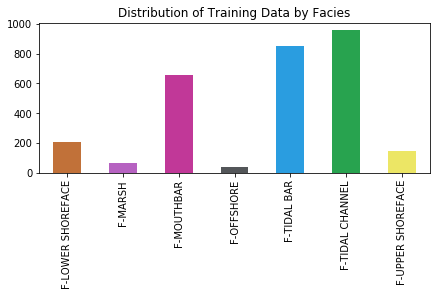

In [37]:
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts


##### Visualization for the reports 

(Not part of the current workflow)

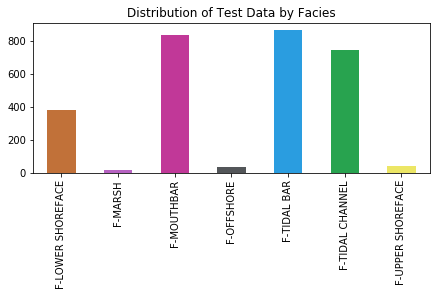

In [38]:
#facies number (instead of by number of entries)
facies_counts2 = test_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts2.index = facies_labels

facies_counts2.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Predicted Facies in Test Data')


#### CONCLUSION

In this study, four supervised machine learning algorithms have been utilized for the classification of lithofacies from geophysical well logs within the ‘Volve’ Field.

The results show that all the algorithms – Naïve Bayes, Support Vector Machine, K-Nearest Neighbour, and Decision Trees – correctly classify at least sixty-eight (68) per cent of the tidal channel sandstones, which is the lithofacies of interest. However, the Support Vector Machine (SVM) classifier is the most effective classifier in this study. 

The results also show that the four machine learning algorithms are currently unable to detect spatial relationships between the well logs samples, and thus are unable to recognize stacking patterns in the gamma ray logs. Consequently, they are unable to correctly classify most of the other lithofacies, within the study area, which have non-uniform gamma ray readings i.e. progradational and aggradational stacking patterns as well as serrated log motifs.